In [ ]:
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize, NonlinearConstraint

import itertools
import scipy
import scipy.integrate as spi
from scipy.integrate import quad
from scipy.special import erf,erfc
#import cvxpy as cp

from sympy import symbols, solve
from scipy.optimize import fsolve, root
from numpy.polynomial import polynomial as P

In [ ]:
def maxim(r,p,beta,alpha):

    def Delta(b,r=r,p=p):
        log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
        return -np.dot(p,log)

    lamb=np.log(beta)/np.log(alpha)

    def constraint1(b,r=r,p=p,lamb=lamb):
        return (p[0]*(b[0]/r[0])**(-lamb)+p[1]*(b[1]/r[1])**(-lamb)+p[2]*(b[2]/r[2])**(-lamb))-1

    def constraint2(b):
        return np.sum(b)-1

    nonlinear_constraint = NonlinearConstraint(constraint1, lb=float('-inf'), ub=0)

    # Define the bounds as before
    bounds = [(0, 1), (0, 1), (0, 1)]

    #constraint_dict_ineq = {'type': 'ineq', 'fun': constraint1}

    # Define the equality constraint dictionary
    constraint_dict_eq = {'type': 'eq', 'fun': constraint2}


    # Minimize the negative of the objective function
    res = minimize(Delta, [1/3, 1/3, 1/3], bounds=bounds, constraints=[nonlinear_constraint, constraint_dict_eq])
    #print(res.x)

    log=(np.log(res.x[0]/r[0]),np.log(res.x[1]/r[1]),np.log(res.x[2]/r[2]))
    log2=((np.log(res.x[0]/r[0]))**2,(np.log(res.x[1]/r[1]))**2,(np.log(res.x[2]/r[2]))**2)
    sigma=(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
    # The maximum value of the original function is the negative of the minimum value found above
    max_value = -res.fun

    return max_value,sigma,res.x

In [ ]:
#Run this if in Colab and want to store figure
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
figures_dir = '/content/gdrive/My Drive/Colab Notebooks'

#If on local machine, uncomment this one (didn't check but should work)
#figures_dir = '.'

Mounted at /content/gdrive


Run the following cell for a complete simulation. Otherwise, jump to the next and load the data from a file

In [ ]:
#Computes P_ext by simulation for the b's obtained by Boyd's method. Compares bound with actual P_ext
#For 3 horses
betas=np.linspace(0.0001,1,50)
#Defining functions

def horse_wins(p):
    #Do the race!
    limits=np.cumsum(p)
    random_num=(random.uniform(0,1))
    #print(random_num)
    check=(random_num<=limits)
    indice_caballo=0
    while ~check[indice_caballo]:
      indice_caballo+=1
    return indice_caballo

#Common parameters
#Save data to GDrive? Set to empty string to not save
nombre_archivo_out=''

#For races simulation
alpha=0.6#Sets the threshold (alpha) for the capital
threshold=np.log(alpha)
initial_capital=1
num_realizations=40000 #number of realizations for P_ext computation.
num_races=100

#The number of colors define how many p's and r's combinations we are doing
colors=['r','b','g']

#Declaring variables
filas=len(betas)
col=len(colors)
b0_opt=np.zeros(filas)
b1_opt=np.zeros(filas)
b2_opt=np.zeros(filas)
W_opt=np.zeros((filas,col))
sigma_opt=np.zeros((filas,col))
P_ext=np.zeros((filas,col))

#Either choose p,r at random (True) or something else
aleatorio=False
figu=plt.figure()
for l in range(0,len(colors)):
  #p=(0.1,0.2,0.7)
  #r=(0.7,0.1,0.2)
  #Define the gambling game
  if aleatorio:
    p=np.random.uniform(0,1,3)
    p=p/sum(p)
    r=np.random.uniform(0,1,3)
    #r=r/sum(r)*np.random.uniform(0.5,1.5)
    r=r/sum(r)
  else:
    #Some particular choice
    if colors[l]=='r':
      p = np.array([0.35581295, 0.15059079, 0.49359625])
      p=p/sum(p)
      r =  np.array([0.63323307, 0.3093805,  0.05738643])
    elif colors[l]=='b':
      #p =  np.array([0.53675214, 0.42445836, 0.0387895 ])
      #p=p/sum(p)
      #r =  np.array([0.47593254, 0.22226144, 0.30180602])
      #We use D and S choice of parameters for the blue line
      p = np.array([0.1, 0.2, 0.7])
      r = np.array([0.7, 0.1, 0.2])
    else:
      p =  np.array([0.23875268, 0.18079096, 0.58045636])
      p=p/sum(p)
      r =  np.array([0.51224918, 0.06937988, 0.41837095])

  print("----New choices of p and r----")
  print("p = ",p)
  print("r = ",r)
  print("Sum r:",sum(r))
  print("Color: ",colors[l])
  #Maximize W with constraints using maxim() for different betas
  for i in range(0,len(betas)):
    waux,sigmaaux,[b0_opt[i],b1_opt[i],b2_opt[i]]=maxim(r,p,betas[i],alpha)
    b0=b0_opt[i]
    b1=b1_opt[i]
    b2=b2_opt[i]
    log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
    log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)
    W_opt[i,l]=(np.dot(p,log))
    #sigma_opt[i]=(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
  #Simulation with optimal b's

  for i in range(0,len(betas)):
    b=np.array([b0_opt[i],b1_opt[i],b2_opt[i]])
    #b=p#Kelly's
    print(f"Iteration {i} of {len(betas)}")
    #print("beta= ",betas[i])
    #print("b=[",b,"]")
    #print("Deltas:",np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))

    extinctions=0
    for j in range(0,num_realizations-1): #realizations for
      log_capital=np.zeros(num_races);
      log_capital[0]=np.log(initial_capital)
      for k in range(1,num_races): #races for loop
        #Which horse wins? Do the race
        horse=horse_wins(p)
        #print("horse wins:",horse)
        #Compute capital increase
        log_capital[k]=log_capital[k-1]+np.log(b[horse]/r[horse])
        if log_capital[k]<=threshold:
          extinctions=extinctions+1
          break #we can stop simulating once is extinct
      #plt.plot(log_capital)
      #Normalize number of extinctions
    P_ext[i,l]=extinctions/num_realizations
    #print("Num Extinctions: ",extinctions)
    #print("P_ext: ",P_ext[i])
    #print(alpha)
    #print(P_ext_J)

#  plt.plot(W_opt/max(W_opt),P_ext,colors[l])
#  plt.plot(W_opt/max(W_opt),betas,colors[l]+"--")

#Save data to Gdrive
if nombre_archivo_out!='':
  np.savez(f"{figures_dir}/{nombre_archivo_out}.npz",P_ext=P_ext,W_opt=W_opt,betas=betas,colors=colors)

----New choices of p and r----
p =  [0.35581295 0.15059079 0.49359625]
r =  [0.63323307 0.3093805  0.05738643]
Sum r: 1.0
Color:  r


<ipython-input-2-466538522970>:4: RuntimeWarning: divide by zero encountered in log
  log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
<ipython-input-2-466538522970>:10: RuntimeWarning: divide by zero encountered in double_scalars
  return (p[0]*(b[0]/r[0])**(-lamb)+p[1]*(b[1]/r[1])**(-lamb)+p[2]*(b[2]/r[2])**(-lamb))-1


Iteration 0 of 50
Iteration 1 of 50
Iteration 2 of 50
Iteration 3 of 50
Iteration 4 of 50
Iteration 5 of 50
Iteration 6 of 50
Iteration 7 of 50
Iteration 8 of 50
Iteration 9 of 50
Iteration 10 of 50
Iteration 11 of 50
Iteration 12 of 50
Iteration 13 of 50
Iteration 14 of 50
Iteration 15 of 50
Iteration 16 of 50
Iteration 17 of 50
Iteration 18 of 50
Iteration 19 of 50
Iteration 20 of 50
Iteration 21 of 50
Iteration 22 of 50
Iteration 23 of 50
Iteration 24 of 50
Iteration 25 of 50
Iteration 26 of 50
Iteration 27 of 50
Iteration 28 of 50
Iteration 29 of 50
Iteration 30 of 50
Iteration 31 of 50
Iteration 32 of 50
Iteration 33 of 50
Iteration 34 of 50
Iteration 35 of 50
Iteration 36 of 50
Iteration 37 of 50
Iteration 38 of 50
Iteration 39 of 50
Iteration 40 of 50
Iteration 41 of 50
Iteration 42 of 50
Iteration 43 of 50
Iteration 44 of 50
Iteration 45 of 50
Iteration 46 of 50
Iteration 47 of 50
Iteration 48 of 50
Iteration 49 of 50
----New choices of p and r----
p =  [0.1 0.2 0.7]
r =  [0.7 

<Figure size 640x480 with 0 Axes>

In [ ]:
#load the data in the file.
#Jump if you don't need to load it because you just run the preceding cell
nombre_archivo_in="data_40000_alpha06"
data = np.load(f"{figures_dir}/{nombre_archivo_in}.npz")
sorted(data.files)
print(data['colors'])
colors=data['colors']
P_ext=data['P_ext']
W_opt=data['W_opt']
betas=data['betas']
#print(W_opt)


['r' 'b' 'g']


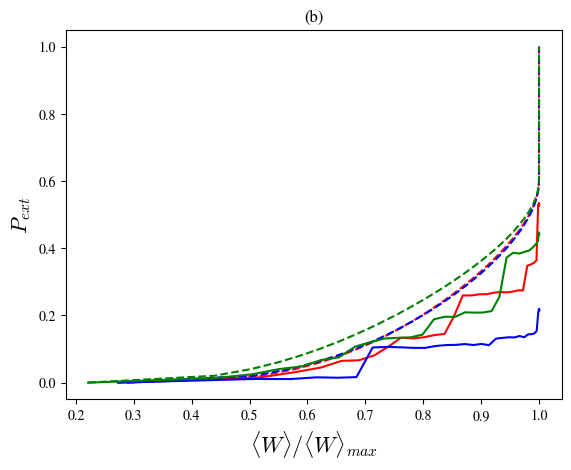

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
for l in range(0,len(colors)):
  plt.plot(W_opt[:,l]/max(W_opt[:,l]),P_ext[:,l],colors[l])
  plt.plot(W_opt[:,l]/max(W_opt[:,l]),betas,colors[l]+"--")
plt.xlabel(r'$\langle W\rangle/\langle W\rangle_{max}$',fontsize=16)
plt.ylabel(r'$P_{ext}$',fontsize=16)
plt.title(r'(b)')
#Saves to google drive
nombre_figura='Pext_Boyd'+'40000r_prDS.pdf'
#plt.savefig(f"{figures_dir}/{nombre_figura}")

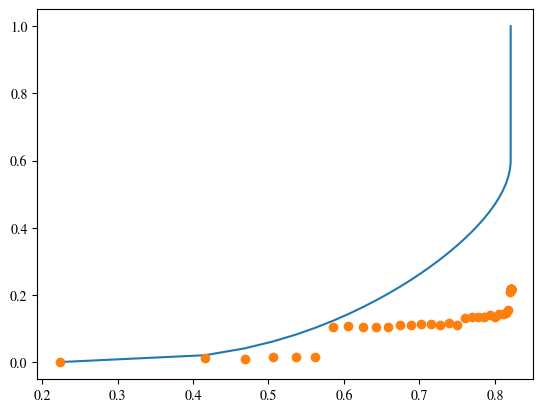

In [ ]:
plt.plot(W_opt[:,1],betas,W_opt[:,1],P_ext[:,1],'o')

In [ ]:
W_opt[:,1]

array([0.22349916, 0.4159948 , 0.46853352, 0.50588126, 0.53610681,
       0.56203365, 0.58501311, 0.60580501, 0.62488024, 0.64255047,
       0.65903134, 0.67447668, 0.68899825, 0.70267796, 0.71557564,
       0.72773397, 0.73918255, 0.74993967, 0.76001403, 0.76940648,
       0.77811019, 0.78611138, 0.79338936, 0.79991694, 0.80565996,
       0.81057712, 0.81461949, 0.81772984, 0.81984173, 0.82087835,
       0.82097249, 0.82097249, 0.82097249, 0.82097249, 0.82097249,
       0.82097249, 0.82097249, 0.82097249, 0.82097249, 0.82097249,
       0.82097249, 0.82097249, 0.82097249, 0.82097249, 0.82097249,
       0.82097249, 0.82097249, 0.82097249, 0.82097249, 0.82097249])

In [ ]:
P_ext[:,1]

array([2.50000e-05, 1.09000e-02, 1.07000e-02, 1.58250e-02, 1.46000e-02,
       1.65000e-02, 1.04625e-01, 1.06275e-01, 1.05075e-01, 1.03575e-01,
       1.03300e-01, 1.09050e-01, 1.11800e-01, 1.12375e-01, 1.14825e-01,
       1.11925e-01, 1.15125e-01, 1.11550e-01, 1.31025e-01, 1.33200e-01,
       1.35050e-01, 1.34575e-01, 1.38725e-01, 1.35075e-01, 1.43750e-01,
       1.44225e-01, 1.46775e-01, 1.54250e-01, 2.09350e-01, 2.14675e-01,
       2.13350e-01, 2.17500e-01, 2.16100e-01, 2.15900e-01, 2.18025e-01,
       2.14075e-01, 2.18825e-01, 2.15125e-01, 2.16000e-01, 2.17650e-01,
       2.16100e-01, 2.13125e-01, 2.15875e-01, 2.17425e-01, 2.18450e-01,
       2.18600e-01, 2.16150e-01, 2.16850e-01, 2.16150e-01, 2.15325e-01])